# Introduction
This document explores how to build efficient functions that add sets of features to our datasets. The goal is to use this functions to easily re-apply the same preprocessing steps to different datasets. Specifically, we will add features related to the following concepts:
- Add time-related features (`hour`, `dow`, `day`)
- Remove records without a passenger count
- Average passenger numbers
- Headway

In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("20211001_20211029_M7.csv")
df.shape

/Users/Lars/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(383785, 24)

# Add time-related features

In [20]:
def add_time_features(df, timestamp_str="timestamp"):
    """
    Given a pd.DataFrame with a timestamp column, return a pd.DataFrame like df, but with
    additional columns "hour", "day", "dow" (day of week)
    
    pd.DataFrame df
    String timestamp_str: name of timestamp column in df
    returns df
    """
    df['timestamp_dt'] = pd.to_datetime(df.timestamp)
    df['hour'] = df['timestamp_dt'].dt.hour
    df['day'] = df['timestamp_dt'].dt.day
    df['dow'] = df['timestamp_dt'].dt.weekday
    return df

In [22]:
df = add_time_features(df)
df.shape

(383785, 28)

# Remove records without a passenger count

We witness two values in the `passenger_count` field that denote records for which there is no such count available:
- `NaN`
- `None`

In this following function, we will remove these records.

In [23]:
def remove_missing_count(df):
    df = df[df.passenger_count.notna()]
    df = df[df.passenger_count != "None"]
    df['passenger_count'] = df.passenger_count.astype(int)
    return df

The following cell demonstrates this process.

In [24]:
df_count = remove_missing_count(df)
df_count.shape

(154482, 28)

In [25]:
df_count.passenger_count.unique()

array([  8,  10,  11,   9,   7,   5,   4,   3,   2,   1,   6,  12,  13,
        14,  15,  17,  21,  23,  25,  20,  18,  27,  19,  16,  29,  35,
        41,  40,  34,  33,  22,  26,  24,  30,  28,  31,  32,  48,  47,
        44,  43,  42,  38,  37,  36,  39,  45,  49,  52,  51,  55,  58,
        61,  64,  71,  46,  74,  73,  80,  84,  85,  87,  89,  93,  92,
        91,  90,  95,  96,  98,  99, 100, 101, 103, 105, 110,  53,  56,
        57,  59,  65,  66,  75,  79,  81,  83,  86,  94, 107, 106,  50,
        63,  62,  67,  68,  70,  69,  76,  77,  78,  88, 102,  54,  60,
        82,  72,  97, 104, 108, 109])

<AxesSubplot:>

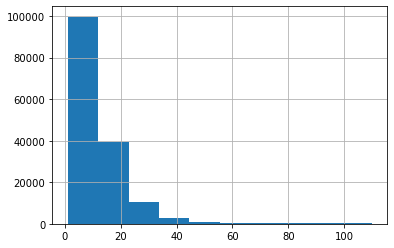

In [26]:
df_count.passenger_count.hist()

Indeed, right now we only have valid passenger count values. 

# Add average passenger numbers

In [32]:
def add_mean_counts(df, hour=True, dow=True, day=True, stop_column="next_stop_id"):
    if hour:
        df_hour = df.groupby([stop_column, 'hour'])['passenger_count'].mean()
        df = df.join(df_hour, on=[stop_column, 'hour'], rsuffix="_mean_hr")
    if dow:
        df_dow = df.groupby([stop_column, 'dow'])['passenger_count'].mean()
        df = df.join(df_dow, on=[stop_column, 'dow'], rsuffix="_mean_dow")
    if day:
        df_day = df.groupby([stop_column, 'day'])['passenger_count'].mean()
        df = df.join(df_day, on=[stop_column, 'day'], rsuffix="_mean_day")
    return df

In [36]:
df_count = add_mean_counts(df_count)

df_count[
    ['passenger_count_mean_hr', 'passenger_count_mean_dow', 'passenger_count_mean_day']
].head()

,passenger_count_mean_hr,passenger_count_mean_dow,passenger_count_mean_day
2,3.631579,14.734043,14.431818
7,4.363636,15.147541,14.900000
12,4.909091,15.714724,15.820225
16,3.789474,14.432749,15.857143
23,6.222222,14.432099,13.636364


# Add headway information